In [ ]:
import pandas as pd

df = pd.read_csv("/content/finale data .csv")
df.head()


,date,temperature,humidity,rainfall,solar_radiation,wind_speed,soil_moisture,PV_output,cluster,irrigation_decision,irrigation_level,irrigation_volume_L
0,2022-12-31,10.1080,48.2635,0.0000,7.176667,1.1715,0.5220,1.93770,2,1,medium,40
1,2023-01-01,9.2220,50.1890,0.0000,9.583333,1.6015,0.5215,2.58750,2,1,medium,40
2,2023-01-02,9.4145,54.0230,0.0005,12.455000,1.1820,0.5205,3.36285,2,1,medium,40
3,2023-01-03,9.0290,59.6420,0.0465,11.931667,1.3410,0.5195,3.22155,2,1,medium,40
4,2023-01-04,8.5855,48.4540,0.0085,12.603333,1.3925,0.5185,3.40290,2,1,medium,40


In [ ]:
# Partie 1

Episode 0 | Loss = 6573.20
Episode 100 | Loss = 7.04
Episode 200 | Loss = 1.21
Episode 300 | Loss = 1.99
Episode 400 | Loss = 0.46
Episode 500 | Loss = 0.80
Episode 600 | Loss = 2.91
Episode 700 | Loss = 0.97
Episode 800 | Loss = 0.14
Episode 900 | Loss = 0.10

===== DQN TEST METRICS =====
MAE: 1.4864864864864864
RMSE: 7.02312781631691
R2: 0.8543464193270061


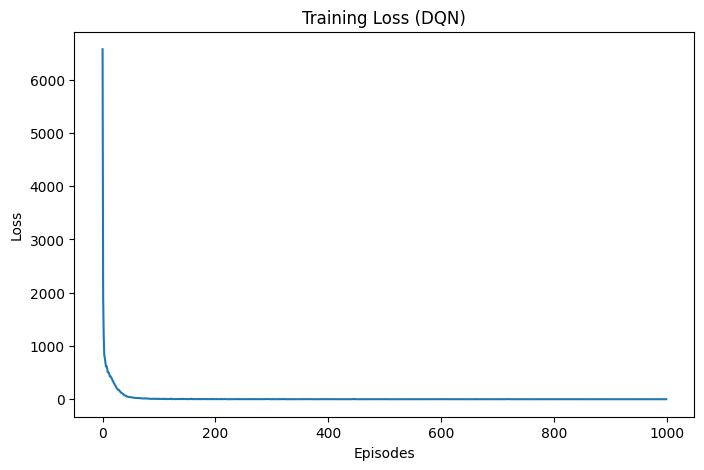

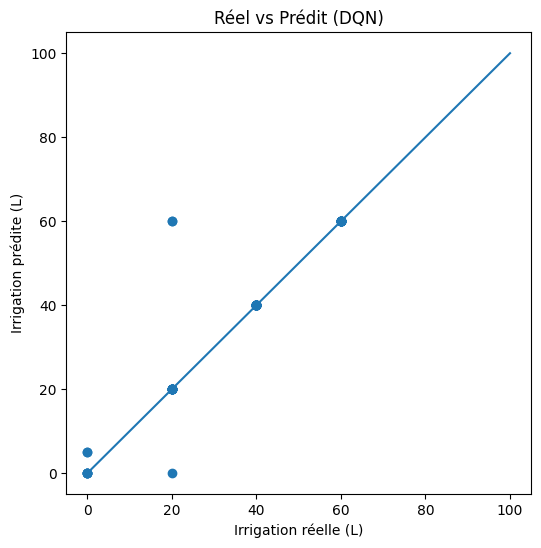

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
df = pd.read_csv("/content/finale data .csv")

X = df[["humidity","rainfall","solar_radiation","wind_speed","soil_moisture","PV_output"]].values
y = df["irrigation_volume_L"].values

# TRAIN / TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== NORMALIZATION =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

actions = list(range(0,101,5))   # 0..100 litres step 5
n_actions = len(actions)

# DQN MODEL
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,n_actions)
        )
    def forward(self,x):
        return self.net(x)

model = DQN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()


memory = deque(maxlen=3000)

gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
batch_size = 64
episodes = 1000
loss_history = []


for ep in range(episodes):
    total_loss = 0

    for i in range(len(X_train_scaled)):

        state = torch.FloatTensor(X_train_scaled[i])


        if np.random.rand() < epsilon:
            action = np.random.randint(n_actions)
        else:
            with torch.no_grad():
                action = torch.argmax(model(state)).item()

        real = y_train[i]
        reward = -abs(real - actions[action])

        next_state = torch.FloatTensor(X_train_scaled[(i+1) % len(X_train_scaled)])

        memory.append((state, action, reward, next_state))


        if len(memory) > batch_size:
            batch = random.sample(memory, batch_size)
            states, actions_b, rewards, next_states = zip(*batch)

            states = torch.stack(states)
            next_states = torch.stack(next_states)

            q_values = model(states)
            next_q = model(next_states).detach()

            target = q_values.clone().detach()

            for j in range(batch_size):
                target[j, actions_b[j]] = rewards[j] + gamma * torch.max(next_q[j])

            loss = loss_fn(q_values, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    loss_history.append(total_loss)

    if ep % 100 == 0:
        print(f"Episode {ep} | Loss = {total_loss:.2f}")

y_pred_dqn = []

for i in range(len(X_test_scaled)):
    state = torch.FloatTensor(X_test_scaled[i])
    with torch.no_grad():
        pred = torch.argmax(model(state)).item()
    y_pred_dqn.append(actions[pred])

mae = mean_absolute_error(y_test, y_pred_dqn)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_dqn))
r2 = r2_score(y_test, y_pred_dqn)
print("\n===== DQN TEST METRICS =====")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
plt.figure(figsize=(8,5))
plt.plot(loss_history)
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.title("Training Loss (DQN)")
plt.show()
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_dqn)
plt.plot([0,100],[0,100])
plt.xlabel("Irrigation réelle (L)")
plt.ylabel("Irrigation prédite (L)")
plt.title("Réel vs Prédit (DQN)")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# PARTIE 2 : RL OPTIMISATION EAU–ENERGIE

✅ Training terminé

===== PARTIE 2 METRICS =====
MAE irrigation: 0.22 L
Energy violations: 0.55 %
Reward moyen: -0.33
Water saving: -0.54 %


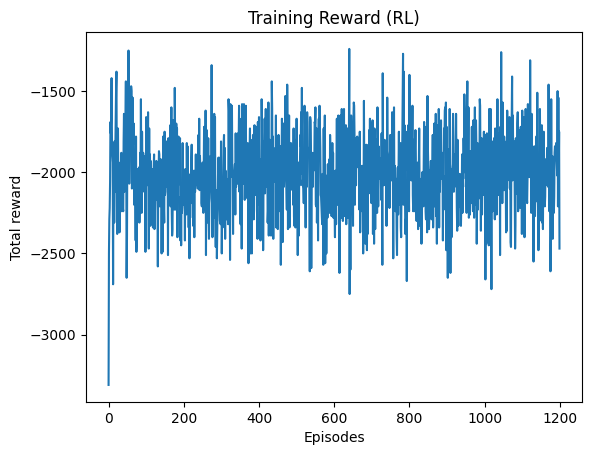

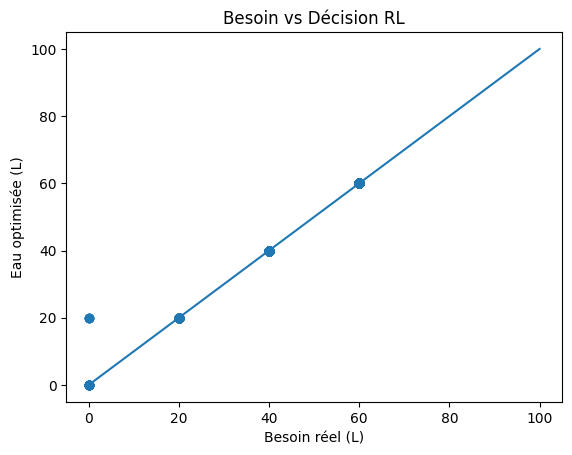

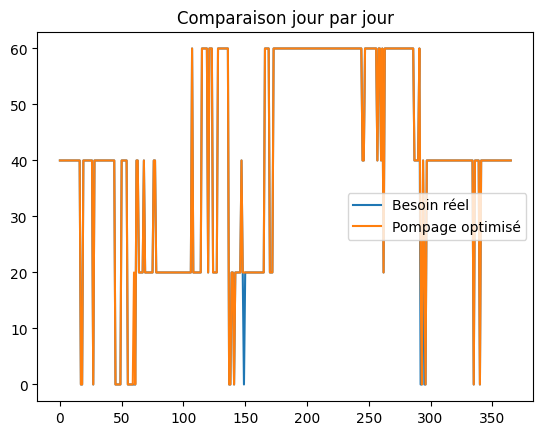

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
df = pd.read_csv("/content/finale data .csv")
actions = [0, 10, 20, 40, 60]
n_actions = len(actions)
bins_need = [20,40,60,80]
bins_pv   = [2,4,6,8]
bins_soil = [0.45,0.50,0.55,0.60]
Q = np.zeros((5,5,5,n_actions))
alpha = 0.1
epsilon = 0.2
episodes = 1200
def discretize(v, bins):
    return np.clip(np.digitize(v,bins)-1,0,len(bins))
reward_history = []
for ep in range(episodes):
    total_reward = 0
    for _,row in df.iterrows():

        besoin = row["irrigation_volume_L"]
        pv = row["PV_output"]
        soil = row["soil_moisture"]

        s1 = discretize(besoin,bins_need)
        s2 = discretize(pv,bins_pv)
        s3 = discretize(soil,bins_soil)
        if random.random() < epsilon:
            action = random.randint(0,n_actions-1)
        else:
            action = np.argmax(Q[s1,s2,s3])

        eau = actions[action]
        energy_req = eau*5
        energy_av  = pv*100
        penalty = 0
        if energy_req > energy_av:
            penalty = 20

        reward = -abs(besoin-eau) - penalty
        total_reward += reward

        Q[s1,s2,s3,action] += alpha*(reward - Q[s1,s2,s3,action])

    reward_history.append(total_reward)

print("✅ Training terminé")
y_real = []
y_opt  = []
violations = 0
rewards_test = []

for _,row in df.iterrows():

    besoin = row["irrigation_volume_L"]
    pv = row["PV_output"]
    soil = row["soil_moisture"]

    s1 = discretize(besoin,bins_need)
    s2 = discretize(pv,bins_pv)
    s3 = discretize(soil,bins_soil)

    action = np.argmax(Q[s1,s2,s3])
    eau = actions[action]

    energy_req = eau*5
    energy_av  = pv*100

    penalty = 0
    if energy_req > energy_av:
        penalty = 20
        violations += 1

    reward = -abs(besoin-eau) - penalty

    y_real.append(besoin)
    y_opt.append(eau)
    rewards_test.append(reward)
mae = mean_absolute_error(y_real,y_opt)
violation_rate = violations/len(df)*100
mean_reward = np.mean(rewards_test)
water_saving = 100*(1 - np.sum(y_opt)/np.sum(y_real))

print("\n===== PARTIE 2 METRICS =====")
print("MAE irrigation:", round(mae,2),"L")
print("Energy violations:", round(violation_rate,2),"%")
print("Reward moyen:", round(mean_reward,2))
print("Water saving:", round(water_saving,2),"%")
plt.figure()
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total reward")
plt.title("Training Reward (RL)")
plt.show()
plt.figure()
plt.scatter(y_real,y_opt)
plt.plot([0,100],[0,100])
plt.xlabel("Besoin réel (L)")
plt.ylabel("Eau optimisée (L)")
plt.title("Besoin vs Décision RL")
plt.show()
plt.figure()
plt.plot(y_real,label="Besoin réel")
plt.plot(y_opt,label="Pompage optimisé")
plt.legend()
plt.title("Comparaison jour par jour")
plt.show()


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
df = pd.read_csv("/content/finale data .csv")
actions = [0, 10, 20, 40, 60]
n_actions = len(actions)
bins_need = [20, 40, 60, 80]
bins_pv   = [1, 1.5, 2, 3, 5, 8]
bins_soil = [0.45, 0.50, 0.55, 0.60]
Q = np.zeros((5, 7, 5, n_actions))
alpha = 0.1
epsilon = 0.2
episodes = 1000
def discretize(v, bins):
    return np.clip(np.digitize(v, bins) - 1, 0, len(bins))
reward_history = []
for ep in range(episodes):
    total_reward = 0
    for _, row in df.iterrows():

        besoin = row["irrigation_volume_L"]
        pv = row["PV_output"]
        soil = row["soil_moisture"]

        s1 = discretize(besoin, bins_need)
        s2 = discretize(pv, bins_pv)
        s3 = discretize(soil, bins_soil)
        valid_actions = [a for a in actions if a * 5 <= pv * 100]

        if len(valid_actions) == 0:
            eau = 0
        else:
            if random.random() < epsilon:
                eau = random.choice(valid_actions)
            else:
                q_vals = [Q[s1, s2, s3, actions.index(a)] for a in valid_actions]
                eau = valid_actions[np.argmax(q_vals)]
        reward = -abs(besoin - eau)
        total_reward += reward

        a_idx = actions.index(eau)
        Q[s1, s2, s3, a_idx] += alpha * (reward - Q[s1, s2, s3, a_idx])

    reward_history.append(total_reward)

print(" Training RL terminé")
y_real = []
y_opt = []
violations = 0
for _, row in df.iterrows():
    besoin = row["irrigation_volume_L"]
    pv = row["PV_output"]
    soil = row["soil_moisture"]
    s1 = discretize(besoin, bins_need)
    s2 = discretize(pv, bins_pv)
    s3 = discretize(soil, bins_soil)
    valid_actions = [a for a in actions if a * 5 <= pv * 100]
    if len(valid_actions) == 0:
        eau = 0
    else:
        q_vals = [Q[s1, s2, s3, actions.index(a)] for a in valid_actions]
        eau = valid_actions[np.argmax(q_vals)]
    if eau * 5 > pv * 100:
        violations += 1
    y_real.append(besoin)
    y_opt.append(eau)
mae = mean_absolute_error(y_real, y_opt)
violation_rate = violations / len(df) * 100
print("\n===== PARTIE 2 METRICS =====")
print("MAE irrigation :", round(mae, 2), "L")
print("Energy violations :", round(violation_rate, 2), "%")
# TEST D'UN JOUR
row = df.iloc[0]   # 31/12/2022
besoin = row["irrigation_volume_L"]
pv = row["PV_output"]
soil = row["soil_moisture"]
s1 = discretize(besoin, bins_need)
s2 = discretize(pv, bins_pv)
s3 = discretize(soil, bins_soil)
valid_actions = [a for a in actions if a * 5 <= pv * 100]
if len(valid_actions) == 0:
    eau_opt = 0
else:
    q_vals = [Q[s1, s2, s3, actions.index(a)] for a in valid_actions]
    eau_opt = valid_actions[np.argmax(q_vals)]
energy_req = eau_opt * 5
energy_av  = pv * 100

print("\n===== TEST JOUR REEL =====")
print("Date :", row["date"])
print("Besoin eau :", besoin, "L")
print("PV_output :", round(pv, 2))
print("Soil moisture :", round(soil * 100, 1), "%")

print("\nDécision RL :", eau_opt, "L")
print("Energie requise :", energy_req, "Wh")
print("Energie dispo :", round(energy_av, 1), "Wh")

if energy_req <= energy_av:
    print("✅ Energie respectée")
else:
    print("❌ Violation énergétique (impossible)")


✅ Training RL terminé

===== PARTIE 2 METRICS =====
MAE irrigation : 0.27 L
Energy violations : 0.0 %

===== TEST JOUR REEL =====
Date : 2022-12-31
Besoin eau : 40 L
PV_output : 1.94
Soil moisture : 52.2 %

Décision RL : 20 L
Energie requise : 100 Wh
Energie dispo : 193.8 Wh
✅ Energie respectée


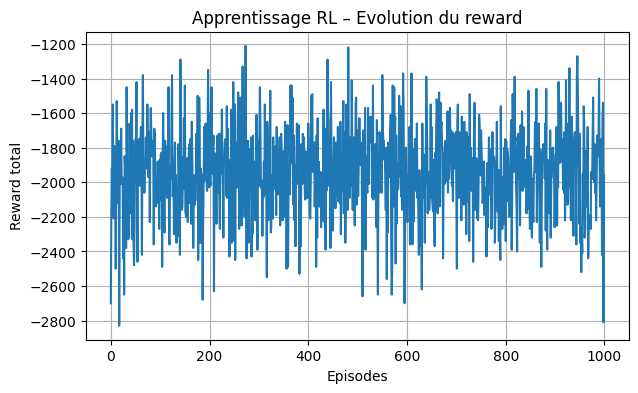

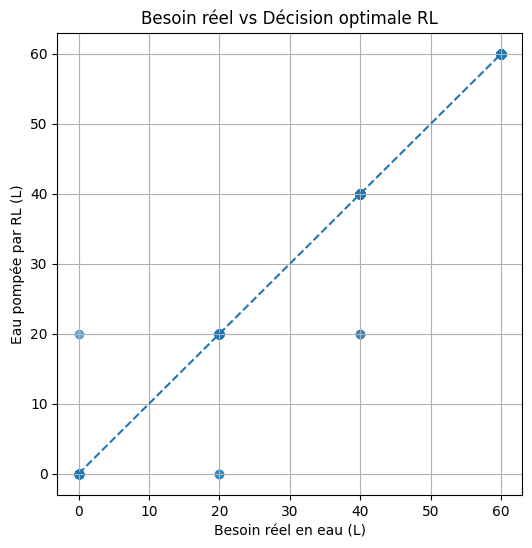

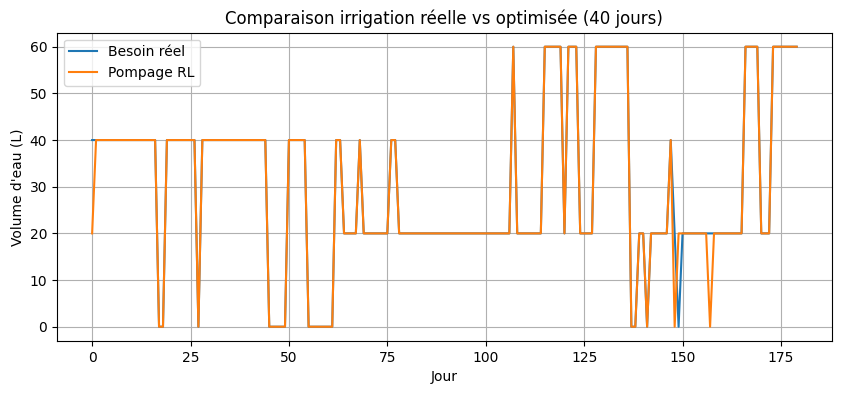

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Reward total")
plt.title("Apprentissage RL – Evolution du reward")
plt.grid(True)
plt.show()
plt.figure(figsize=(6,6))
plt.scatter(y_real, y_opt, alpha=0.6)
plt.plot([0, max(y_real)], [0, max(y_real)], linestyle="--")
plt.xlabel("Besoin réel en eau (L)")
plt.ylabel("Eau pompée par RL (L)")
plt.title("Besoin réel vs Décision optimale RL")
plt.grid(True)
plt.show()
plt.figure(figsize=(10,4))
plt.plot(y_real[:180], label="Besoin réel")
plt.plot(y_opt[:180], label="Pompage RL")
plt.xlabel("Jour")
plt.ylabel("Volume d'eau (L)")
plt.title("Comparaison irrigation réelle vs optimisée (180 jours)")
plt.legend()
plt.grid(True)
plt.show()
